In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
from dataclasses import dataclass, field

## Self-defined ConvLSTM Layer

default parameter initialization by pytorch is used

reference: https://github.com/automan000/Convolutional_LSTM_PyTorch/blob/master/convolution_lstm.py#L15

In [2]:
#Original ConvLSTM Paper with extra terms
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        assert hidden_channels % 2 == 0
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 5#check this one
        self.padding = (kernel_size - 1)//2
        
        self.Wxi = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whi = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxf = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whf = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxc = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Whc = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wxo = nn.Conv1d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = True)
        self.Who = nn.Conv1d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias = False)
        self.Wci = None
        self.Wcf = None
        self.Wco = None
        
    def forward(self, x, h, c):
        #x_t, h_(t-1), c_(t-1)
        i_t = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c*self.Wci)
        f_t = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c*self.Wcf)
        c_t = f_t*c + i_t*torch.tanh(self.Wxc(x) + self.Whc(h))
        o_t = torch.sigmoid(self.Wxo(x) + self.Who(h) + c_t*self.Wco)
        h_t = o_t*torch.tanh(c_t)
        return h_t, c_t
    def init_hidden(self, batch_size, hidden, size):
        self.Wci = nn.Parameter(torch.zeros(1, hidden, size))
        self.Wcf = nn.Parameter(torch.zeros(1, hidden, size))
        self.Wco = nn.Parameter(torch.zeros(1, hidden, size))
        return (torch.zeros(batch_size, hidden, size), torch.zeros(batch_size, hidden, size))
        
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, step = 1, effective_step = [1]):
        super().__init__()
        self.channels = [input_channels] + hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = "cell{}".format(i)
            cell = ConvLSTMCell(self.channels[i], self.channels[i+1], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)
    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                name = "cell{}".format(i)
                if step == 0:
                    bsize,_,size = x.size()
                    h,c = getattr(self, name).init_hidden(batch_size = bsize, hidden = self.channels[i+1], size = size)
                    internal_state.append((h,c))
                h,c = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = x, new_c
            if step in self.effective_step:
                outputs.append(x)
        return x#outputs, (x, new_c)

## Hyperparameters
evaluating 10 quantiles, using 60% data for training, 15% for validation and the rest for testing<br>
the remaining hyperparameters are tuned based on performance<br>
<br>
filename: file name for the data<br>
beststate: file name to save the best model<br>
lagperiod: no. of period used for input (no. of hours in this case)<br>
forecast: forecast horizon (no. of hours ahead)<br>
numfeatures: no. of assets in the data, inputed after loading data <br>
hidden: no. of hidden units for Convolutional LSTM<br>
batch:batch size <br>
lr: learning rate <br>
output: no. of outputs, 1 prediction+ 10 quantiles = 11 for this case, inputed after loading data


In [3]:
#Config Parameters
@dataclass
class Args:
    filename:str = "crypto_data.csv"
    beststate:str = "model_best_state_ConvLSTM"
    quantiles:list = field(default_factory = lambda:[0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95])
    trainfrac:float = 0.6
    valfrac:float = 0.15
    lagperiod:int = 60
    forecast:int = 2
    numfeatures:int = None
    hidden:int = 40
    batch:int = 128
    lr:float = 0.0001
    output:int = None
    dropout:float = 0.1
    kernel:int = 5
    epochs:int = 60

## Load Data
crypto_data.csv compiles all 9 crypto data on the repo

first column (date) is excluded 

data is split into inputs (X) and labels(Y)

In [4]:
#Load & Split Data
def get_data(args):
    data = np.array(pd.read_csv(args.filename))[:,1:].astype("float32")
    alldata = np.array([data[i+1]/data[i]-1 for i in range(len(data)-1)])
    torch.set_default_dtype(torch.float32)
    X = torch.tensor(np.array([alldata[i-args.lagperiod:i] for i in range(args.lagperiod, len(alldata))]))
    Y = alldata[args.lagperiod+args.forecast:]
    return X,Y

## Split Data
data is split into train, validation and testing sets using dataloaders

In [5]:
def get_loader(X,Y,args):
    i_train = int(len(Y)*args.trainfrac)
    i_val = int(len(Y)*(args.valfrac+args.trainfrac))
    end = len(Y)
    train_iter = torch.utils.data.DataLoader(list(zip(X[:i_train],torch.tensor(Y[:i_train]))), batch_size=args.batch, shuffle = True)
    val_iter = torch.utils.data.DataLoader(list(zip(X[i_train:i_val],Y[i_train:i_val])), batch_size=args.batch, shuffle = False)
    test_iter = torch.utils.data.DataLoader(list(zip(X[i_val:end],Y[i_val:end])), batch_size=args.batch, shuffle = False)
    return train_iter, val_iter, test_iter, i_train, i_val

## Evaluation & Loss Functions (per sample)
The functions below are defined such that hopefully, they could be used in both MLP and ConvLSTM implementations.
For the inputs to these functions, they are defined as follows:
1. $\hat{y}$: prediction with shape (sample size)  x (outputs = 1 mean + 10 quantiles) x (no. of features = 9)
2. $y$: observation with shape (sample size) x (no. of features = 9), corresponds to Y_'s in the cell above
3. $\tau$: quantile vector of length (J=10)

$y$ and $\hat{y}$ are tensors for loss function and numpy array for evaluation functions.
<br>
### Loss Function
As defined in the paper, the loss function is the sum of mean squared errors and tilted loss. The for loop computes the 2nd summation.
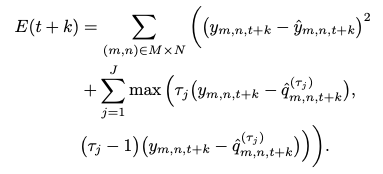

In [6]:
#Evaluation & Loss Functions
def lossfn(τ, y, ŷ):
    loss = torch.mean(torch.square(y-ŷ[:,0,:]))
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += torch.mean(q*r - r*(r<0))
    return loss

### Tilted Loss
Similar to the 2nd summation in loss function. Tilted loss is evaluated on quantiles only which is why the 2nd index (i+1) ranges from 1 to 10 for $\hat{y}$.
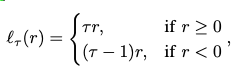

In [7]:
#for evaluation: remember to turn tensors into np.array()
def tilted_loss(τ, y, ŷ):
    loss = 0.0
    for i in range(len(τ)):
        q = τ[i]
        r = y - ŷ[:,i+1,:]
        loss += np.mean(q*r - r*(r<0))
    return loss

### Crossing Loss & Number of Crosses
Crossing loss and number of crosses are evaluated on neighbouring quantiles only which is why we have the 2nd indices of (i+1) and (i+2) (same reason as tilted loss) and for loop range of (11-2=9) for 10 quantiles.
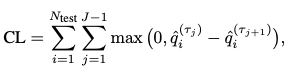

In [8]:
def crossing_loss(ŷ):
    loss = 0.0 #crossing loss as defined in the paper
    num_cross = 0.0
    for i in range(ŷ.shape[1]-2):
        q = ŷ[:,i+1,:] - ŷ[:,i+2,:]
        loss += np.sum(np.maximum(q,0))
        num_cross += np.sum(q>0)
    loss /= ŷ.shape[0]*(ŷ.shape[1]-2)
    num_cross /= ŷ.shape[0]
    return loss, num_cross

### Interval Coverage Percentage (ICP) & Mean Interval Length (MIL)
ICP: the fraction of observations (y) that are within the prediction interval
<br>MIL: the average length of the prediction interval
<br> (lower , upper) is the corresponding pair of predicted quantiles e.g. 5% and 95% quantiles, 10% and 90% quanatiles etc

In [9]:
def eval_quantiles(lower, upper, y):
    icp = np.mean((y > lower) & (y < upper))
    mil = np.mean(np.maximum(0,upper-lower))
    return icp,mil

### Errors (MSE, RMSE, MAE)
Standard error functions evaluated on predicted means only. Therefore, the 2nd index for $\hat{y}$ is 0

correct_sign computes the fraction of predictions that gets the sign correctly

In [10]:
def eval_error(y, ŷ):
    r = np.abs(y-ŷ[:,0,:])
    mse = np.mean(r*r)
    rmse = np.sqrt(mse)
    mae = np.mean(r)
    correct_sign = np.mean(y*ŷ[:,0,:]<0)/(1-np.mean(y*ŷ[:,0,:]==0))
    return mse, rmse, mae, correct_sign

### Checking Quantiles
1. determines the quality of quantiles (mainly for 40% and 60% quantiles)
2. determines % of time where we will execute trades
3. determines % of trades executed that are profitable

In [11]:
def check_quantiles(y,ŷ,i_low,i_high,numfeatures):
    #1. accuracy of quantiles
    print("1. Fraction of :")
    print("true return > 40% quantile:",np.mean(y > ŷ[:,i_low,:]))
    print("true return < 60% quantile:",np.mean(y < ŷ[:,i_high,:]))
    #2. volume of trades
    print("2. Fraction of ")
    print("40% quantiles > 0:",np.mean(ŷ[:,i_low,:]>0))
    print("60% quantiles < 0:",np.mean(ŷ[:,i_high,:]<0))
    #3. profitability
    print("3. Probability of:")
    print("true return > 0 given 40% quantile > 0:", np.mean([[ŷ[i,i_low,j]>0 and y[i,j]>0 for i in range(len(ŷ))] for j in range(numfeatures)])/np.mean(ŷ[:,i_low,:]>0))
    print("true return < 0 given 60% quantile < 0:", np.mean([[ŷ[i,i_high,j]<0 and y[i,j]<0 for i in range(len(ŷ))] for j in range(numfeatures)])/np.mean(ŷ[:,i_high,:]<0))

evaluates errors

In [12]:
def eval(y,ŷ, model, quantiles):
    closs, num_cross = crossing_loss(ŷ)
    tl = tilted_loss(quantiles, y, ŷ)
    mse, rmse, mae, correct_sign = eval_error(y, ŷ)
    icp, mil = [], []
    for i in range(len(quantiles)//2):
        t1,t2 = eval_quantiles(ŷ[:,i+1,:],ŷ[:,len(quantiles)-i,:],y)
        icp.append(t1)
        mil.append(t2)
    return closs, num_cross, tl, mse, rmse, mae, correct_sign, icp, mil

print errors

In [13]:
def print_error(closs, num_cross, tl, mse, rmse, mae, correct_sign, icp, mil, quantiles):
    print("Crossing Loss:", closs, ", Number of Crosses:", num_cross)
    print("MSE:",mse, "RMSE:", rmse,"MAE:", mae)
    print("Tilted loss:", tl)
    print("Prediction Intervals:")
    for i in range(len(quantiles)//2):
        print(round((quantiles[len(quantiles)-i-1]-quantiles[i])*100),"% ICP & MIL:",icp[i],mil[i])
    print("the model predicts the sign correctly in ", correct_sign*100,"% of the cases (excluding 0)")

## Model Initialization
on top of ConvLSTM, there's a final output layer which, according to DeepJMQR's author, is equivalent to a 1x1 linear convolutional layer
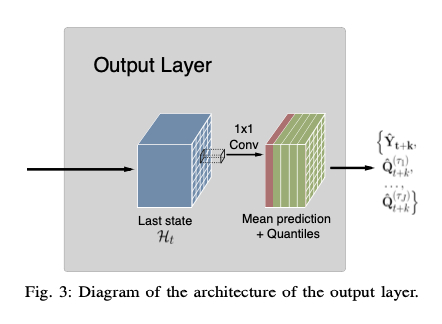

In [14]:
#Initialize Model
def make_model(args):
    net = nn.Sequential(nn.BatchNorm1d(args.lagperiod, affine = False),
                        ConvLSTM(args.lagperiod, [args.hidden], args.kernel),
                        nn.Dropout1d(args.dropout),
                        nn.Conv1d(args.hidden, args.output, 1, bias = True))
    return net

### Training & Validation
inputs data in batches into the model to make predictions, evaluates loss value and makes adjustment to parameters (when training), then returns average loss value across batches

Reference: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

"The Training Loop" & "Per-Epoch Activity"

In [15]:
#Train Model
def train_one_epoch(model, train_iter, optimizer, quantiles):
    running_loss = 0.0
    for i, data in enumerate(train_iter):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfn(quantiles, labels, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        last_loss = loss.item()
    return running_loss / (i+1)

In [16]:
def val_one_epoch(model, val_iter, quantiles):
    running_vloss = 0.0
    for i, vdata in enumerate(val_iter):
        vinputs, vlabels = vdata
        voutputs =  model(vinputs).detach().numpy()
        vloss = lossfn(quantiles, vlabels, voutputs)
        running_vloss += vloss
    return running_vloss / (i+1)

## Main Training Function
trains the model, visualizes training and validation loss, saves the best performing model

In [17]:
def train(X,Y,args):
    train_iter, val_iter, test_iter, i_train, i_val = get_loader(X,Y,args)
    model = make_model(args)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = args.lr)
    animator = d2l.Animator(xlabel = "epoch", ylabel = "loss", xlim = [1,args.epochs], legend = ["train", "val"])
    best_vloss = 1e9
    for i in range(args.epochs):
        running_loss = 0.0
        model.train(True)
        avg_loss = train_one_epoch(model, train_iter, optimizer, args.quantiles)
        model.eval()
        running_vloss = 0.0
        avg_vloss = val_one_epoch(model, val_iter, args.quantiles)
#         if epoch % (n_epochs/20) == 0:
        animator.add(i+1, (avg_loss, avg_vloss))
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model, args.beststate)
    model = torch.load(args.beststate)
    return model, i_train, i_val

## Main Body

In [18]:
def explore(args):
    q40index = args.quantiles.index(0.4)+1
    q60index = args.quantiles.index(0.6)+1
    X,Y = get_data(args)
    args.numfeatures = Y.shape[1]
    args.output = len(args.quantiles)+1
    model, i_train, i_val = train(X,Y,args)
    X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
    pred = model(X_val).detach().numpy()
    closs, num_cross, tl, mse, rmse, mae, correct_sign, icp, mil = eval(Y_val, pred, model, args.quantiles)
    print_error(closs, num_cross, tl, mse, rmse, mae, correct_sign, icp, mil, args.quantiles)
    print()
    check_quantiles(Y_val, pred,q40index, q60index, args.numfeatures)

### Some Observations
1. the 40% and 60% quantiles are roughly at the right position
2. the fraction of times where trades are executed (40% quantile > 0 and 60% quantile < 0) is quite low
3. the probability of gaining profit is over 50% for both quantiles

Crossing Loss: 1.2577966707213695e-06 , Number of Crosses: 0.02822448309812931
MSE: 0.000108969834 RMSE: 0.010438861 MAE: 0.0070395507
Tilted loss: 0.02447044861037284
Prediction Intervals:
90 % ICP & MIL: 0.917952084017066 0.03347528
80 % ICP & MIL: 0.833278634722678 0.023335319
60 % ICP & MIL: 0.6332640484265033 0.013614821
40 % ICP & MIL: 0.4296028880866426 0.008177014
20 % ICP & MIL: 0.21576778616489808 0.0038528652
the model predicts the sign correctly in  48.556826120528 % of the cases (excluding 0)

1. Fraction of :
true return > 40% quantile: 0.599824964445903
true return < 60% quantile: 0.6159428217189951
2. Fraction of 
40% quantiles > 0: 0.10152062137621705
60% quantiles < 0: 0.032016920103562704
3. Probability of:
true return > 0 given 40% quantile > 0: 0.5326867816091954
true return < 0 given 60% quantile < 0: 0.5284738041002278


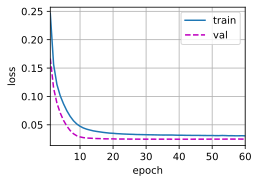

In [19]:
args = Args(epochs = 60, lagperiod = 60, forecast = 2)
explore(args)

### Visualization
plots predicted 40% & 60% quantiles and true returns

observe that the predicted quantiles are able to capture the change in variance of the true values as proposed in the paper
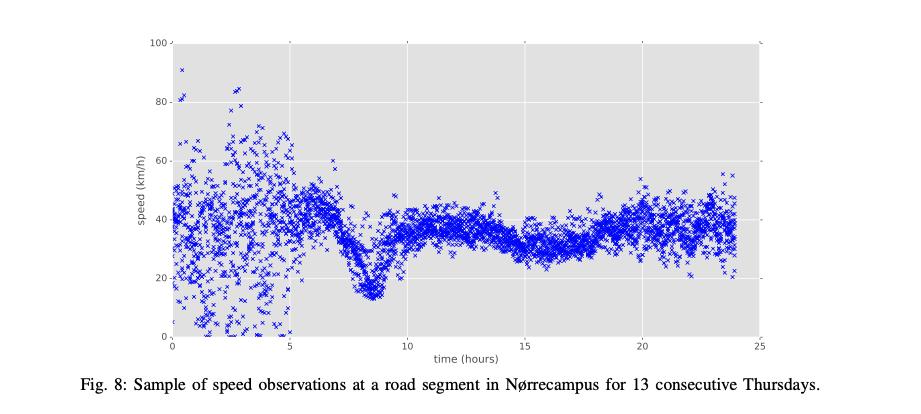


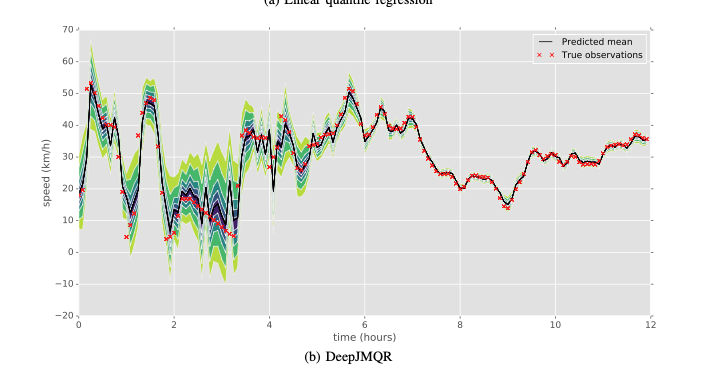

In [20]:
def visualize(args, sec = 0):
    q40index = args.quantiles.index(0.4)+1
    q60index = args.quantiles.index(0.6)+1
    model = torch.load(args.beststate)
    X,Y = get_data(args)
    i_train = int(len(Y)*args.trainfrac)
    i_val = int(len(Y)*(args.valfrac+args.trainfrac))
    X_val, Y_val = X[i_train:i_val], Y[i_train:i_val]
    pred = model(X_val).detach().numpy()
    s = sec
    df = pd.DataFrame(np.vstack((Y_val[:,s],pred[:,q40index,s],pred[:,q60index,s])).transpose(), columns = ["trues","40%","60%"])
    df.plot(lw=0.5)

input sec with values from 0 to 8 to view the quantile performance for all 9 assets

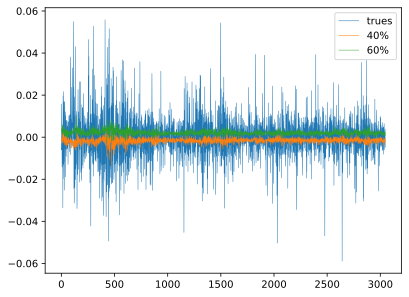

In [21]:
visualize(args, sec = 0)